## Introduction

In this notebook we show how to use `LazySets` to compute the intersection area between two-dimensional sets.

This notebook was motivated by https://github.com/JuliaAstro/Photometry.jl/issues/22

We use version LazySets v1.32.1

In [2]:
] st LazySets

    Status `~/.julia/environments/v1.3/Project.toml`
  [d1acc4aa] IntervalArithmetic v0.16.6 #v0.16.6 (https://github.com/JuliaIntervals/IntervalArithmetic.jl.git)
  [b4f0291d] LazySets v1.32.1 [`~/.julia/dev/LazySets`]
  [3cdcf5f2] RecipesBase v0.7.0


In [7]:
using LazySets

There are about 40 set representations available in `LazySets`. This count includes set representations (polygons, hyperrectangles, ellipsoids, etc) and also *lazy set* operations such as different kinds of maps, convex hulls, minkowski sums and so on (more on this below). To see all the concrete subtypes of `LazySet` do `subtypes(LazySet, true)` or naviagate through the [online documentation](
https://juliareach.github.io/LazySets.jl/dev/#Library-Outline-1).

In the rest of the notebook we'll assume that one is given two sets, `A` and `B`, such that:

- `A` is a hyperrectangle in 2D.
- `B` is the linear map of a hyperrectangle in 2D.

We will first create these sets and then compute their intersection area.

## Creating some data

In LazySets, `Hyperrectangle` is the set type that represents an axis-aligned hyperrectangle. Let's create a random hyperrectangle in the plane:

In [141]:
A = rand(Hyperrectangle)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.5197914538783582, 0.5329907881005042], [0.5469470723467329, 0.9836508651828213])

Hyperrectangles are represented by their center and their vector radius. Although you can access their fields directly, we suggest that you use the appropriate getter functions.

In [142]:
center(A)

2-element Array{Float64,1}:
 0.5197914538783582
 0.5329907881005042

In [143]:
radius_hyperrectangle(A)

2-element Array{Float64,1}:
 0.5469470723467329
 0.9836508651828213

Sets can simple be plotted using the Julia [Plots](http://docs.juliaplots.org/latest/) library:

In [144]:
using Plots
using LazySets: center # to avoid conflicts with Plots

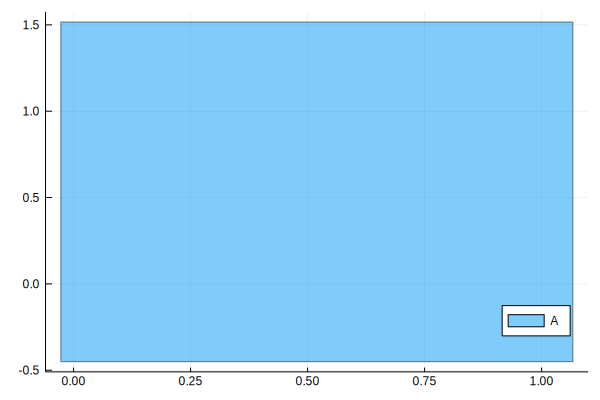

In [158]:
plot(A, lab="A", legend=:bottomright)

There are different ways to construct hyperrectangles; for example you can pass the center and vector radius as in `Hyperrectangle(c, r)`. But a hyperrectangle can also be thought as the (cartesian) product of intevals, and one can pass the lower / upper bounds for each interva through `Hyperrectangle(low=l, high=h)`. For examples see the documentation of the `Hyperrectangle` constructor, either typing `?Hyperrectangle` or in the [online documentation](https://juliareach.github.io/LazySets.jl/dev/lib/sets/Hyperrectangle/#LazySets.Hyperrectangle).

Now we consider a set obtained by taking a hyperrectangle and mapping it through a linear map. In other words, let `X` be a hyperrectangle and `M` be a 2x2 matrix, and we consider the set $B = \{y\in \mathbb{R}^2 : y = Mx, x \in X\}$.

In [146]:
M = rand(2, 2)

2×2 Array{Float64,2}:
 0.68771    0.41426 
 0.0522136  0.648397

In [147]:
X = rand(Hyperrectangle)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([1.150049497978626, 1.1356926076420273], [0.14978532626789537, 0.8788105439720555])

In `LazySets` we can create such set `B` using the usual `*` symbol between a matrix and a set:

In [148]:
B = M * X

LinearMap{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}},Float64,Array{Float64,2}}([0.6877104766744175 0.4142596807391421; 0.05221358972526091 0.6483972840168317], Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([1.150049497978626, 1.1356926076420273], [0.14978532626789537, 0.8788105439720555]))

If you see the output, you'll notice that the type of the returned object is a `LinearMap`. The type parameters correspond to the numeric types of the set, the set type, the numeric type of the matrix, and finally the matrix type.

In [149]:
typeof(B)

LinearMap{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}},Float64,Array{Float64,2}}

Now what `LinearMap` is a *lazy linear map* set representation. This means that it behaves as the set `B`, although no actual computations where done when the object was created: they are done a posteriori, but this is transparent to the user.

For example, we can plot `B`:

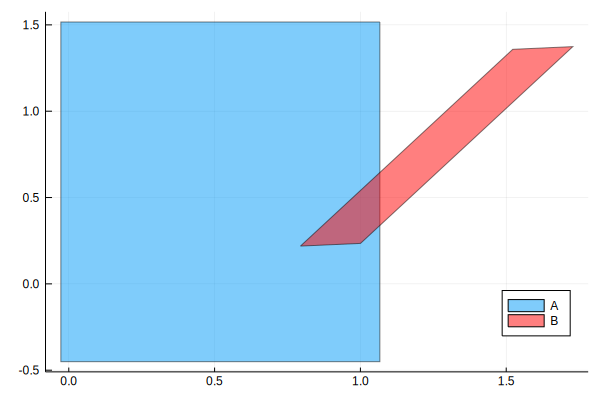

In [159]:
plot!(B, color=:red, lab="B")

In [160]:
Z = linear_map(M, X)

Zonotope{Float64,Array{Float64,1},Array{Float64,2}}([1.2613727455136454, 0.7964282149242821], [0.10300893812652748 0.3640557753760555; 0.007820829572616235 0.5698183698768352])

On the other hand, the *concrete* linear map can be computed using the function `linear_map`.

**Tip.** As with the linear map example, all lazy operations names are CamelCase, while concrete operations are declared with lower-case words separated by underscores.

Now the concrete linear map of `M` and `X` returns a [zonotope](https://juliareach.github.io/LazySets.jl/dev/lib/sets/Zonotope/), which is a set represented by a center and a list of generators.

The properties of `Z` and `B` should of course match, eg. we can compute their lists of vertices:

In [161]:
vertices_list(B)

4-element Array{Array{Float64,1},1}:
 [1.7284374590162284, 1.3740674143737333] 
 [1.5224195827631735, 1.3584257552285008] 
 [0.7943080320110624, 0.21878901547483057]
 [1.0003259082641174, 0.23443067462006306]

In [162]:
vertices_list(Z)

4-element Array{Array{Float64,1},1}:
 [1.7284374590162284, 1.3740674143737335] 
 [1.5224195827631735, 1.358425755228501]  
 [0.7943080320110625, 0.21878901547483065]
 [1.0003259082641174, 0.23443067462006306]

Or we can simply check that they represent the same type (up to the given [tolerance](https://juliareach.github.io/LazySets.jl/dev/lib/comparisons/#LazySets.Tolerance)) by making a double inclusion test: 

In [163]:
Z ⊆ B && B ⊆ Z

true

## Intersections and area of overlap

We are interested in the (concrete) intersection between `A` and `B` so we can do:

In [164]:
C = intersection(A, B)

HPolytope{Float64,Array{Float64,1}}(HalfSpace{Float64,Array{Float64,1}}[HalfSpace{Float64,Array{Float64,1}}([0.07570590880575503, -0.9971301897805996], -0.15802732108722006), HalfSpace{Float64,Array{Float64,1}}([0.8426928042027843, -0.5383946858438039], 0.7167512153375664), HalfSpace{Float64,Array{Float64,1}}([-0.8426928042027843, 0.5383946858438039], -0.5515628196435505), HalfSpace{Float64,Array{Float64,1}}([1.0, 0.0], 1.066738526225091)])

This function has created a [HPolytope](https://juliareach.github.io/LazySets.jl/dev/lib/sets/HPolytope/#LazySets.HPolytope), which is a convex polytope in half-space representation (that is, the finite intersection of half-spaces).

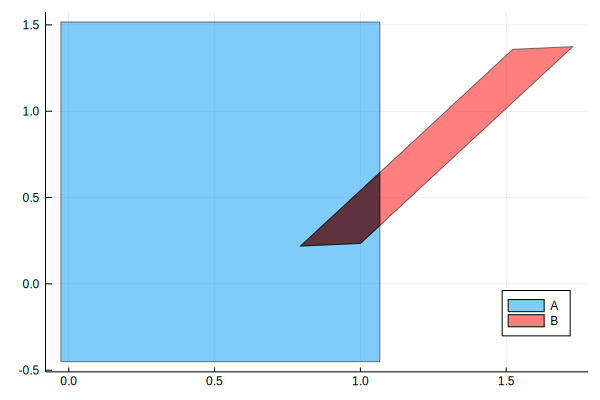

In [165]:
plot!(C, color=:black)

The area of a 2D set can be computed using the `area` function which uses the Shoelace formula, see the documentation of [LazySets.area](https://juliareach.github.io/LazySets.jl/dev/lib/interfaces/#LazySets.area-Union{Tuple{LazySet{N}},%20Tuple{N}}%20where%20N) for details.

In [167]:
area(C)

0.05198133596399823

## A note on performance

In this paragraph we consider a faster implementation of the overlap area. We use the fact that we are working in two dimensions hence we convert the inputs to `HPolygon`, that has optimized implementations for most operations. In constrast, the fallbacks are designed to work for any dimension and any set representation.

For reference, let's benchmak our first implementation.

In [168]:
using BenchmarkTools

In [175]:
function overlap_area_v1(A::Hyperrectangle{N}, B::LinearMap{N, <:Hyperrectangle{N}}) where {N}
    C = intersection(A, B)
    return area(C)
end

overlap_area_v1 (generic function with 2 methods)

In [180]:
@btime overlap_area_v1($A, $B)

  115.659 μs (755 allocations: 70.92 KiB)


0.05198133596399823

Now we consider the refined implementation, where `A` and `B` are converted to polygons.

In [181]:
# the idea is to use the intersection for HPolygon, which is faster than the fallback because the
# normal vectors to the half-spaces are sorted in counter--clockwise fashion 
function overlap_area_v2(A::AbstractHyperrectangle{N},
                         B::LinearMap{N, <:AbstractHyperrectangle{N}}) where {N}
    A_clist = A |> constraints_list
    A_poly = HPolygon(A_clist, sort_constraints=true, prune=false, check_boundedness=false)
    
    B_clist = linear_map(matrix(B), set(B)) |> constraints_list
    B_poly = HPolygon(B_clist, sort_constraints=true, prune=false, check_boundedness=false)

    return intersection(A_poly, B_poly) |> area
end

overlap_area_v2 (generic function with 1 method)

In [182]:
@btime overlap_area_v2($A, $B)

  14.138 μs (332 allocations: 37.55 KiB)


0.05198133596399823

The gain by using the `HPolygon` function is about a factor of 10x than the fallback implementation.

## Conclusion

In this notebook we showed how to use `LazySets` to create some two-dimensional sets, compute intersections and compute the overlap area.

We discussed with the linear map example that set operations can be lazy or concrete. This depends on the application -- typically lazy operations outperform concrete operations if one is working with high-dimensional sets or is handling long chains of array expressions, eg. the minkowski sum of a large array of 2D sets.

We saw how to use existing algorithms in `LazySets` for the problem of area of overlap of two-dimensional sets. By suitably converting to a set type that implements the intersection in two-dimensions, we had some "free" performance gains compared to using the fallback implementation. This simple case illustrates that specialization is the key for having good performance.

As a final remark, let us note that to a large extent, the "power" of LazySets is based on a suitable choice of Julia's multiple dispatch system and this makes the library very easy to extend. For instance, suppose that you have a better way to compute the overlap are of the intersection of two sets `A` and `B` where `A` is a hyperrectangle and `B` is the linear map of a hyperrectangle. Then you can leverage on the lazy intersection operation, `Intersection`, and dispatch on that operation for the set types of interest:

```julia
function area(X::Intersection{N, Hyperrectangle{N}, LinearMap{N, Hyperrectangle}})
     # my new function
end
```

It should be clear that form the user's perspective this is great because whenever `area` is called for this particular operation defined by `X`, Julia will choose the specialized version instead of the fallback.

---